In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Параметры настройки
GAUSSIAN_BLUR_SIZE = (51, 51)
ADAPTIVE_THRESH_BLOCK_SIZE = 11
ADAPTIVE_THRESH_C = 2
CONTOUR_AREA_THRESHOLD = 100
RECTANGLE_COLOR = (0, 255, 0)  # BGR
RECTANGLE_THICKNESS = 10
NUM_BLUR_ITERATIONS = 5
NUM_LARGEST_CONTOURS = 1


def show_image(subplot, title, image):
    subplot.imshow(image, cmap='gray')
    subplot.title.set_text(title)


def blur_image(img):
    # Преобразуем изображение в оттенки серого
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Применяем адаптивную пороговую функцию
    _, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Применяем размытие
    blur = cv2.GaussianBlur(threshold, GAUSSIAN_BLUR_SIZE, 0)

    # Для дебага размытия
    _, img_binary = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY_INV)

    return blur, img_binary


def find_contour(blur):
    # Ищем контуры
    contours, _ = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Фильтруем контуры
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > CONTOUR_AREA_THRESHOLD]

    # Сортируем контуры по площади
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Берем контуры с самыми большими площадями
    contours = contours[:NUM_LARGEST_CONTOURS]
    for cnt in contours:
        cv2.drawContours(blur, [cnt], -1, (255, 0, 0), 5)

    return contours[0] if contours else None


def find_rotation(orig_img, contour):
    hull = cv2.convexHull(contour, clockwise=True, returnPoints=True)
    # вычисляем минимальный ориентированный прямоугольник, охватывающий все точки
    rect = cv2.minAreaRect(hull)
    (center, (width, height), angle) = rect

    # получаем углы ориентированного прямоугольника
    box = cv2.boxPoints(rect)
    box = np.int0(box)  # преобразовываем координаты в целые числа

    # print(hull)
    print(box)
    print((center, (width, height), angle))

    # Угол rect всегда в интервале [-90, 0). Переведем его в интервал [0, 180) для ясности
    if width < height:
        angle += 90

    print("Угол поворота: ", angle)

    # Если угол поворота ближе к 90 или 0, производим коррекцию
    if abs(angle - 90) <= 3:
        corrected_angle = angle - 90
    elif abs(angle) <= 3:
        corrected_angle = angle
    else:
        corrected_angle = 0

    print("Коррекция угла: ", corrected_angle)
    # Получаем матрицу поворота
    rot_mat = cv2.getRotationMatrix2D(center, corrected_angle, 1.0)
    # Применяем поворот к изображению
    result = cv2.warpAffine(orig_img, rot_mat, orig_img.shape[1::-1], flags=cv2.INTER_LINEAR)

    box = cv2.boxPoints(rect).astype('int')
    return result, box


def draw_lines(img, box):
    draw_img = img.copy()
    cv2.drawContours(draw_img, [box], -1, (255, 0, 0), 3)
    for (x, y) in box:
        cv2.circle(draw_img, (x, y), 10, (0, 255, 0), -1)

    # рисуем линии
    cv2.line(draw_img, tuple(box[0]), tuple(box[1]), (0, 255, 0), 2)  # верхняя горизонтальная линия
    cv2.line(draw_img, tuple(box[1]), tuple(box[2]), (0, 255, 0), 2)  # правая вертикальная линия
    cv2.line(draw_img, tuple(box[2]), tuple(box[3]), (0, 255, 0), 2)  # нижняя горизонтальная линия
    cv2.line(draw_img, tuple(box[3]), tuple(box[0]), (0, 255, 0), 2)  # левая вертикальная линия

    cv2.line(draw_img, tuple(box[0]), tuple(box[2]), (0, 0, 255), 2)  # первая диагональная линия
    cv2.line(draw_img, tuple(box[1]), tuple(box[3]), (0, 0, 255), 2)  # вторая диагональная линия

    return draw_img


def rotate_processing(image, show=False):
    contour_image = np.zeros_like(image)
    blur, binary_img = blur_image(img=image)
    contour = find_contour(blur=blur)
    rotated_img, box = find_rotation(orig_img=image, contour=contour)

    if show:
        draw_img = draw_lines(img=image, box=box)
        draw_cnt_img = draw_lines(img=contour_image, box=box)

        # Выводим изображения
        fig, axs = plt.subplots(1, 5, figsize=(20, 20))
        show_image(axs[0], 'Исходное изображение', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        show_image(axs[1], 'Бинаризация и размытие', blur)
        show_image(axs[2], 'Контур с крайними точками', cv2.cvtColor(draw_cnt_img, cv2.COLOR_BGR2RGB))
        show_image(axs[3], 'Наложение линий на оригинал', cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
        show_image(axs[4], 'Повернутое изображение', cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
        plt.show()

    return rotated_img


/var/folders/1_/ss0tzds95cjf19d6s8b1cdf80000gn/T/ipykernel_35384/1307233738.py:63: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)  # преобразовываем координаты в целые числа


[[ 221 1457]
 [2046 1367]
 [2137 3218]
 [ 312 3308]]
((1179.26904296875, 2337.9970703125), (1853.3121337890625, 1827.2037353515625), 87.19754791259766)
Угол поворота:  87.19754791259766
Коррекция угла:  -2.8024520874023438


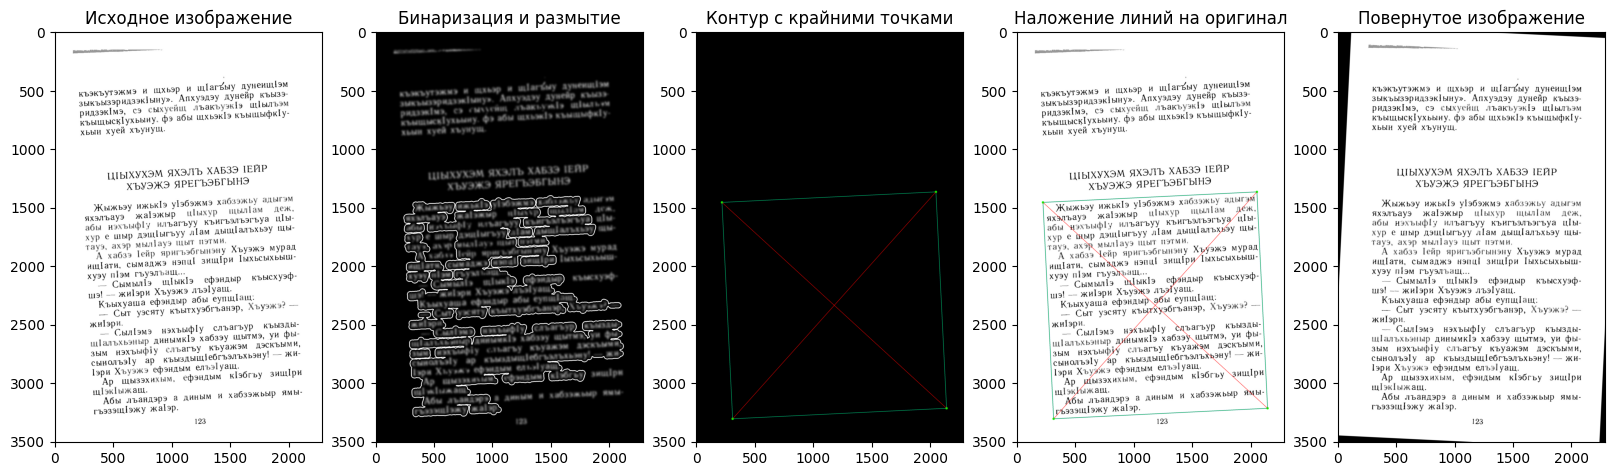

[[ 264 3261]
 [ 271 1408]
 [2097 1415]
 [2089 3268]]
((1180.647705078125, 2338.397705078125), (1825.765380859375, 1852.9705810546875), 0.22207553684711456)
Угол поворота:  90.22207553684711
Коррекция угла:  0.22207553684711456


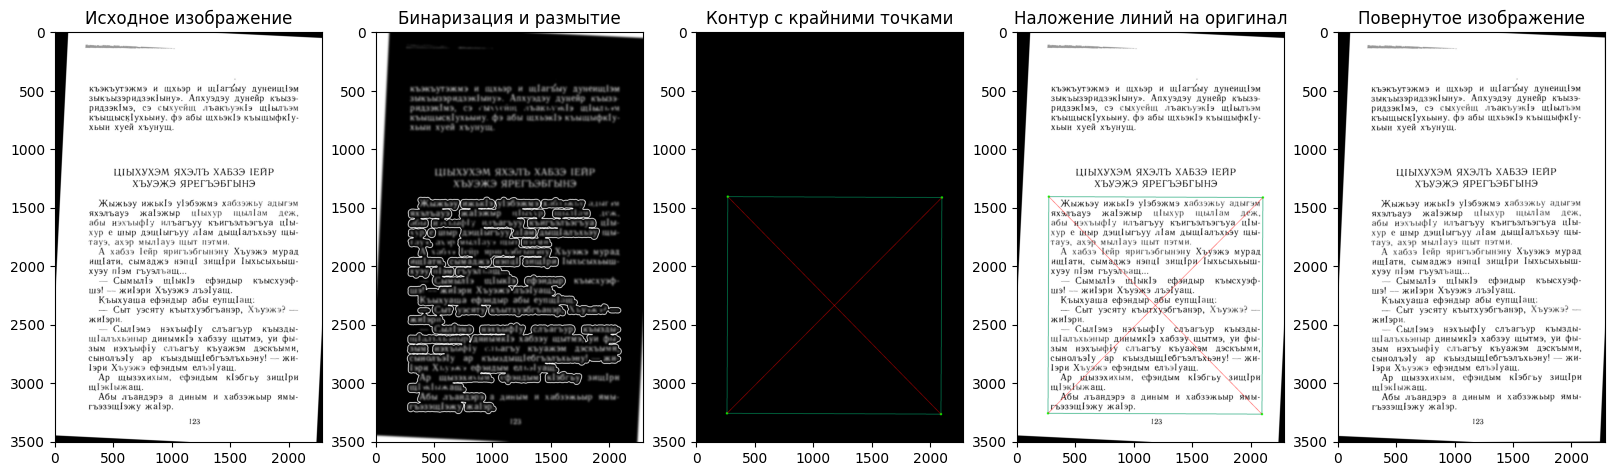

In [5]:
image_path = 'images/input/108-khuezhe-i-taurykhkher.pdf-122.jpg'

orig_image = cv2.imread(image_path)

rotated_img = rotate_processing(orig_image, show=True)
rotated_2_img = rotate_processing(rotated_img, show=True)


In [3]:
import os

output_dir = 'images/output/image_descew_by_text'
os.makedirs(output_dir, exist_ok=True)

cv2.imwrite(f'{output_dir}/orig_image.jpg', orig_image)
cv2.imwrite(f'{output_dir}/rotated_img.jpg', rotated_img)

error: OpenCV(4.8.0) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'
